In [1]:
import glob
import pandas as pd 
import sqlite3
import os
import numpy  as np 

# Prepare Data for Processing

In [2]:
if False:
    pd.read_sql('''SELECT 
                        name
                    FROM 
                        sqlite_master 
                    WHERE 
                        type ='table' AND 
                        name NOT LIKE 'sqlite_%';
    ''', con=conn)

In [81]:
glob.glob('../data/diffengine-diffs/spark-output/*')

NameError: name 'glob' is not defined

In [82]:
to_run = [
 '../data/diffengine-diffs/spark-output/nyt-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/ap-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/independent-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/reuters-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/guardian-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/wp-matched-sentences.db.gz'
]

In [19]:
def get_sentence_dfs(conn):
    print('getting counts...')
    version_counts = pd.read_sql('''
        SELECT entry_id, 
            CAST(version as INT) as version, 
            COUNT(1) as c from split_sentences 
            GROUP BY entry_id, version
    ''', con=conn)

    print('getting sentences with additions...')
    versions_with_additions = pd.read_sql('''
        with c1 as (
            SELECT 
                entry_id,
                CAST(version_x as INT) as version_x, 
                CAST(version_y as INT) as version_y,
                SUM(sent_idx_x IS NULL) as num_additions
            FROM matched_sentences
            GROUP BY entry_id, version_x, version_y
        )
        SELECT DISTINCT entry_id, version_x, version_y FROM c1 WHERE num_additions > 0
    ''', con=conn)

    versions_with_updates = (
        version_counts
         .merge(
             versions_with_additions, 
             left_on=['entry_id', 'version'],
             right_on=['entry_id', 'version_x']
         )
         .drop('version', axis=1)
    )

    count_weights = (
        versions_with_updates
             .loc[lambda df: df['c'] < 100]
             ['c']
             .pipe(lambda s: pd.cut(s, np.arange(0, 100, 5)))
             .value_counts()
             .pipe(lambda df: 1/df)
    )

    keys_to_get = (
        versions_with_updates
         .assign(c_bin=lambda df: df['c'].pipe(lambda s: pd.cut(s, np.arange(0, 100, 5))))
         .merge(count_weights.to_frame(), right_index=True, left_on='c_bin')
         .pipe(lambda df: df.sample(n=15000, weights=df['c_y']))
         .set_index('entry_id')[['version_x', 'version_y']]
         .unstack().to_frame('version')
         .reset_index().drop('level_0',axis=1)
         .drop_duplicates()
         .dropna()
         .apply(lambda x: '%s-%s' % (x['entry_id'], x['version']), axis=1)
         .tolist()
    )

    joint_keys = "'%s'" % "', '".join(keys_to_get)

    print('getting split sentences...')
    split_sentences = pd.read_sql('''
        with c1 AS (
            SELECT *, entry_id || '-' || CAST(version AS INT) as key FROM split_sentences
        )
        SELECT entry_id, CAST(version AS INT) as version, sent_idx, sentence 
        FROM c1
        WHERE key IN (%s)
    ''' % joint_keys, con=conn)

    # return 
    return split_sentences

In [114]:
t = get_sentence_dfs(conn)

In [6]:
all_dfs = []

In [30]:
for f in to_run[2:]:
    print(f)
    if f.endswith('.gz') and os.path.exists(f):
        ! gunzip -f $f
    
    f = f.replace('.gz', '')

    conn = sqlite3.connect(f)
    df = get_sentence_dfs(conn)
    df['source'] = f.split('/')[-1].split('-')[0]
    print('FETCHED RECORDS:')
    print(df.shape)
    all_dfs.append(df)
    !gzip $f

../data/diffengine-diffs/spark-output/wp-matched-sentences.db.gz
getting counts...
getting sentences with additions...
getting split sentences...
FETCHED RECORDS:
(1064672, 5)
../data/diffengine-diffs/spark-output/independent-matched-sentences.db.gz
getting counts...
getting sentences with additions...
getting split sentences...
FETCHED RECORDS:
(735716, 5)
../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db.gz
getting counts...
getting sentences with additions...
getting split sentences...
FETCHED RECORDS:
(1064226, 5)
../data/diffengine-diffs/spark-output/reuters-matched-sentences.db.gz
getting counts...
getting sentences with additions...
getting split sentences...
FETCHED RECORDS:
(735441, 5)
../data/diffengine-diffs/spark-output/guardian-matched-sentences.db.gz
getting counts...
getting sentences with additions...
getting split sentences...
FETCHED RECORDS:
(1427344, 5)


In [31]:
full_df = pd.concat(all_dfs)

In [34]:
full_df.shape 

(7239663, 5)

In [36]:
full_df.to_csv('../modeling/sentence-df-for-discourse-modeling.csv')

In [63]:
for i, sents in (full_df.head(100)
 .groupby(['source', 'entry_id', 'version'])
 .apply(lambda df: df.sort_values('sent_idx')['sentence'].tolist())
).iteritems():
    i, sents

In [64]:
i

('nyt', 1870586, 10)

In [65]:
full_df

,entry_id,version,sent_idx,sentence,source
0,1819591,1,0,HONG KONG — The protests that have shaken Hong...,nyt
1,1819591,1,1,"Since then, they have become a broader moveme...",nyt
2,1819591,1,2,"Over the course of several weeks, violent clas...",nyt
3,1819591,1,3,"Activists have stormed government offices, hal...",nyt
4,1819591,1,4,And the police’s use of force against demonstr...,nyt
...,...,...,...,...,...
1427339,1100535,10,102,“Both Donald and Marco got very personal and v...,guardian
1427340,1100535,10,103,I’m not going to do that.,guardian
1427341,1100535,10,104,I will happily praise Donald Trump and Marco R...,guardian
1427342,1100535,10,105,"” Butter wouldn’t melt, and etc.",guardian


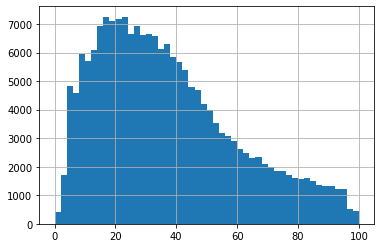

In [46]:
(full_df
 .set_index(['source', 'entry_id', 'version'])
 .assign(c=1)
 .groupby(level=[0,1,2])['c']
 .value_counts()
 .hist(range=(0,100), bins=50)
)

# Get and Interpret Data

In [173]:
import pandas as pd 
import ast
from collections import Counter
def get_counts(x):
    c = Counter()
    c.update(x)
    return dict(c)

In [168]:
file_lines = open('../eda/edit_scores.txt').read().split('\n')

In [169]:
max_len = max(len(file_lines[1::2]), len(file_lines[::2]))
data_df = pd.DataFrame([file_lines[:max_len*3:2], file_lines[1:max_len*3:2]]).T.dropna()
data_df[0] = data_df[0].apply(ast.literal_eval)

In [170]:
sentence_df = pd.read_csv('../modeling/data/sentence-df-for-discourse-modeling.csv', index_col=0)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [172]:
data_df = (
    data_df
        .assign(source=lambda df: df[0].str.get(0))
        .assign(entry_id=lambda df: df[0].str.get(1))
        .assign(version=lambda df: df[0].str.get(2))
        .assign(tags = lambda df: df[1].apply(ast.literal_eval))
        .assign(doc_len=lambda df: df['tags'].str.len())
)

In [214]:
data_df[['doc_len', 'version']].corr(method='spearman')

,doc_len,version
doc_len,1.000000,0.335477
version,0.335477,1.000000


In [174]:
tag_counts = (
    data_df['tags']
        .apply(get_counts)
        .to_frame('counts')
        .assign(Main=lambda df: df['counts'].str.get('Main'))
        .assign(Distant=lambda df: df['counts'].str.get('Distant'))
        .assign(Cause=lambda df: df['counts'].str.get('Cause'))
        .drop('counts', axis=1).fillna(0)
        .assign(doc_len=lambda df: df.sum(axis=1))
)

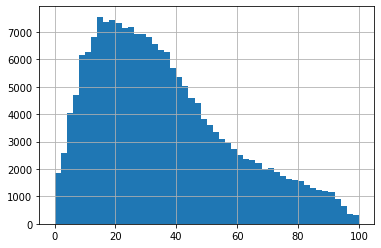

In [56]:
tag_counts['doc_len'].hist(range=(0, 100), bins=50)

In [200]:
tag_counts['doc_len_bin'] = tag_counts['doc_len'].pipe(lambda s: pd.cut(s, range(0,120,20), right=False))

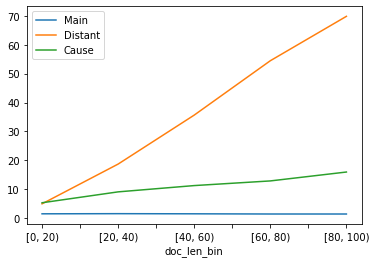

In [71]:
tag_counts.groupby('doc_len_bin')[['Main', 'Distant', 'Cause']].mean().plot()

In [175]:
full_data_df = pd.concat([data_df, tag_counts], axis=1)

In [176]:
import ast
import sqlite3
import glob

In [177]:
all_output = []
for idx, labels in data_df.set_index(['source', 'entry_id', 'version'])[1].iteritems():
    for s_idx, l in enumerate(ast.literal_eval(labels)):
        all_output.append({
            'source': idx[0],
            'entry_id': idx[1],
            'version': idx[2],
            'sent_idx': s_idx,
            'discourse_label': l
        })

In [179]:
discourse_sent_data_df = pd.DataFrame(all_output)

In [180]:
all_add_del_info = []

In [181]:
to_run = glob.glob('../data/diffengine-diffs/spark-output/*')

In [182]:
for f in to_run:
    print(f)
    if '.gz' in f:
        ! gunzip $f
    f = f.replace('.gz', '')
    conn = sqlite3.connect(f)

    add_del_info = pd.read_sql('''
        with added as (
                SELECT entry_id, 
                version_y as version, 
                sent_idx_y as sent_idx, 
                0 as is_deleted,
                CAST((sent_idx_x IS NULL) AS INT) AS is_added
            FROM matched_sentences
                WHERE is_added = 1
        ), deleted as (
            SELECT entry_id, 
                version_x as version, 
                sent_idx_x as sent_idx,
                CAST((sent_idx_y IS NULL) AS INT) AS is_deleted,
                0 as is_added
            FROM matched_sentences
                WHERE is_deleted = 1
        )
        SELECT * from added
        UNION ALL
        SELECT * from deleted
    ''', con=conn)
    add_del_info['source'] = f.split('/')[-1].split('-')[0]
    all_add_del_info.append(add_del_info)

../data/diffengine-diffs/spark-output/wp-matched-sentences.db
../data/diffengine-diffs/spark-output/independent-matched-sentences.db
../data/diffengine-diffs/spark-output/reuters-matched-sentences.db
../data/diffengine-diffs/spark-output/guardian-matched-sentences.db
../data/diffengine-diffs/spark-output/nyt-matched-sentences.db
../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db
../data/diffengine-diffs/spark-output/ap-matched-sentences.db


In [183]:
all_not_add_del = []
for f in to_run:
    print(f)
    if '.gz' in f:
        ! gunzip $f
    f = f.replace('.gz', '')
    conn = sqlite3.connect(f)

    not_add_del = pd.read_sql('''
        with x as (
                SELECT entry_id, 
                version_y as version, 
                sent_idx_y as sent_idx, 
                0 as is_deleted,
                CAST((sent_idx_x IS NULL) AS INT) AS is_added,
                avg_sentence_distance_y <> 0 AS is_edited
            FROM matched_sentences
                WHERE is_added = 0 AND CAST(is_edited AS int) = 0
                LIMIT 160000
        ), y as (
            SELECT entry_id, 
                version_x as version, 
                sent_idx_x as sent_idx,
                CAST((sent_idx_y IS NULL) AS INT) AS is_deleted,
                0 as is_added,
                avg_sentence_distance_x <> 0 AS is_edited
            FROM matched_sentences
                WHERE is_deleted = 0 AND CAST(is_edited AS INT) = 0
                LIMIT 160000
        )
        SELECT * from x
        UNION ALL
        SELECT * from y
    ''', con=conn)
    not_add_del['source'] = f.split('/')[-1].split('-')[0]
    all_not_add_del.append(not_add_del)

../data/diffengine-diffs/spark-output/wp-matched-sentences.db
../data/diffengine-diffs/spark-output/independent-matched-sentences.db
../data/diffengine-diffs/spark-output/reuters-matched-sentences.db
../data/diffengine-diffs/spark-output/guardian-matched-sentences.db
../data/diffengine-diffs/spark-output/nyt-matched-sentences.db
../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db
../data/diffengine-diffs/spark-output/ap-matched-sentences.db


In [184]:
all_not_add_del_df = pd.concat(all_not_add_del)
all_add_del_df = pd.concat(all_add_del_info)

In [185]:
sentence_df_no_null = sentence_df.loc[lambda df: df['sentence'].notnull()]

In [186]:
all_not_add_del_df_w_sents = (all_not_add_del_df
 .merge(
     sentence_df_no_null, 
     left_on=['source', 'entry_id', 'version', 'sent_idx'], 
     right_on=['source', 'entry_id', 'version', 'sent_idx']
 )
)

all_not_add_del_df_w_sents['sentence'] = (
    all_not_add_del_df_w_sents['sentence']
        .str.replace('</p>', '')
        .str.replace('<p>', '')
        .str.replace('\s+', ' ')
        .str.strip()
)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


In [161]:
all_not_add_del_df_w_sents.shape

(285900, 8)

In [162]:
all_not_add_del_df_w_sents.to_csv('../eda/non-edited-sentences.csv')

In [294]:
discourse_sent_data_df

,source,entry_id,version,sent_idx,discourse_label
0,ap,1,0.0,0,Main
1,ap,1,0.0,1,Main
2,ap,1,0.0,2,Cause
3,ap,1,0.0,3,Cause
4,ap,1,0.0,4,Cause
...,...,...,...,...,...
7239632,wp,1971140,2.0,32,Distant
7239633,wp,1971140,2.0,33,Distant
7239634,wp,1971140,2.0,34,Distant
7239635,wp,1971140,2.0,35,Distant


In [297]:
discourse_sent_data_with_add_dels_df = (
    discourse_sent_data_df
     .merge(all_add_del_df,
            left_on=['source','entry_id', 'version', 'sent_idx'], 
            right_on=['source','entry_id', 'version', 'sent_idx'], 
            how='left'
           )
    .assign(is_added=lambda df: df['is_added'].fillna(0))
    .assign(is_deleted=lambda df: df['is_deleted'].fillna(0))
)

In [189]:
(
    discourse_sent_data_with_add_dels_df
     .loc[lambda df: df['is_deleted']==1]
     ['discourse_label']
     .value_counts()
     .pipe(lambda s: s/s.sum())
)

Distant    0.613931
Cause      0.302401
Main       0.048850
Error      0.034818
Name: discourse_label, dtype: float64

In [191]:
(
    discourse_sent_data_with_add_dels_df
     .loc[lambda df: df['is_added']==1]
     ['discourse_label']
     .value_counts()
     .pipe(lambda s: s/s.sum())
)

Distant    0.635333
Cause      0.289674
Main       0.043782
Error      0.031212
Name: discourse_label, dtype: float64

In [192]:
label_dist_overall = (
    discourse_sent_data_with_add_dels_df
     ['discourse_label']
     .value_counts()
     .pipe(lambda df: df / df.sum())
)

In [193]:
label_dist_add = (discourse_sent_data_with_add_dels_df
 .loc[lambda df: df['is_added'] == 1]
 ['discourse_label']
 .value_counts()
 .pipe(lambda df: df / df.sum())
)

In [194]:
label_dist_del = (discourse_sent_data_with_add_dels_df
 .loc[lambda df: df['is_deleted'] == 1]
 ['discourse_label']
 .value_counts()
 .pipe(lambda df: df / df.sum())
)

In [298]:
label_dist_none = (
    discourse_sent_data_with_add_dels_df
    .loc[lambda df: (df['is_added'] == 0 ) & (df['is_deleted'] == 0)]
   ['discourse_label']
   .value_counts()
   .pipe(lambda df: df / df.sum())

)

In [299]:
label_dist_none

Distant    0.680671
Cause      0.236104
Error      0.047382
Main       0.035843
Name: discourse_label, dtype: float64

In [301]:
discourse_sent_data_with_add_dels_df.assign(c=1).groupby(['source','entry_id', 'version'])['c'].sum()

source  entry_id  version
ap      1         0.0        45
                  1.0        48
                  2.0        43
        2         0.0        40
                  1.0        40
                             ..
wp      1971050   3.0        63
        1971138   0.0        19
                  1.0        34
        1971140   1.0        32
                  2.0        37
Name: c, Length: 192909, dtype: int64

In [302]:
discourse_sent_data_with_add_dels_df.shape

(7368634, 7)

In [195]:
label_dist_overall

Distant    0.670816
Cause      0.246880
Error      0.044644
Main       0.037660
Name: discourse_label, dtype: float64

In [196]:
label_dist_add

Distant    0.635333
Cause      0.289674
Main       0.043782
Error      0.031212
Name: discourse_label, dtype: float64

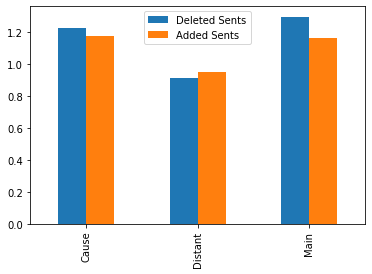

In [197]:
pd.concat([
    (label_dist_del / label_dist_overall).drop('Error').to_frame('Deleted Sents'),
    (label_dist_add / label_dist_overall).drop('Error').to_frame('Added Sents')
], axis=1).plot(kind='bar')

In [215]:
dist_by_len = (
    tag_counts
    .drop('doc_len', axis=1)
    .groupby('doc_len_bin')
    .sum()
    .pipe(lambda df: df.divide(df.sum(axis=1) ,axis=0))
)

In [362]:
import matplotlib.pyplot as plt
plt.rc('font', size=23)

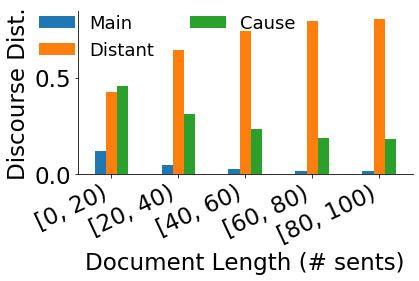

In [363]:
ax = (
    dist_by_len
#     .drop('Error', axis=1)
    .plot(kind='bar', figsize=(6,3))
)#, figsize=(4,3.5))
# ax.legend().set_visible(False)
plt.legend(frameon=False, ncol=2, fontsize=18, bbox_to_anchor=(.28, .57, .42, .51))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Document Length (# sents)')
plt.ylabel('Discourse Dist.')
plt.xticks(rotation=25, horizontalalignment='right')
plt.savefig('figures/tag-dist-by-len.pdf', bbox_inches='tight')
plt.savefig('../presentations/acl2022/figures/tag-dist-by-len.pdf', bbox_inches='tight')

In [230]:
discourse_sent_data_with_add_dels_df = (discourse_sent_data_with_add_dels_df
 .pipe(lambda df: df.merge(
     df.assign(c=1)
         .groupby(['source', 'entry_id', 'version'])['c']
         .sum().to_frame('doc_len').reset_index(),
     right_on=['source','entry_id', 'version'],
     left_on=['source','entry_id', 'version'],
     how='left'
 ))
)

In [231]:
discourse_sent_data_with_add_dels_df['doc_len_bin'] = discourse_sent_data_with_add_dels_df['doc_len'].pipe(lambda s: pd.cut(s, range(0,120,20), right=False))

In [270]:
none_dist_by_pos = (
    discourse_sent_data_with_add_dels_df
    .assign(is_added=lambda df: df['is_added'].fillna(0))
    .assign(is_deleted=lambda df: df['is_deleted'].fillna(0))
    .loc[lambda df: (df['is_added'] == 0 ) & (df['is_deleted'] == 0)].assign(c=1)
    .groupby(['doc_len_bin', 'discourse_label'])['c']
    .sum()
    .unstack()
    .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

In [272]:
added_dist_by_pos = (
    discourse_sent_data_with_add_dels_df
    .loc[lambda df: df['is_added'] == 1].assign(c=1)
    .groupby(['doc_len_bin', 'discourse_label'])['c']
    .sum()
    .unstack()
    .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

In [273]:
del_dist_by_pos = (
    discourse_sent_data_with_add_dels_df
    .loc[lambda df: df['is_deleted'] == 1].assign(c=1)
    .groupby(['doc_len_bin', 'discourse_label'])['c']
    .sum()
    .unstack()
    .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

In [244]:
overall_dist_over_tags = tag_counts[['Main', 'Distant','Cause']].sum().pipe(lambda s: s/s.sum())

In [252]:
overall_dist_over_position = tag_counts.groupby('doc_len_bin')[['Main', 'Distant', 'Cause']].sum().sum(axis=1).pipe(lambda s: s/s.sum())

Text(0, 0.5, 'Del. Odds, by Discourse')

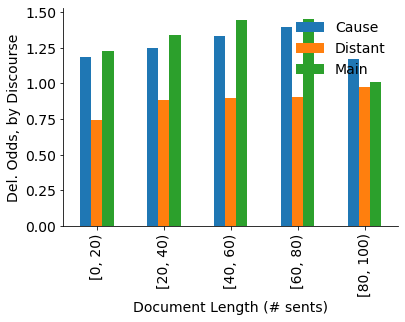

In [280]:
ax = (
    (del_counts_by_pos / none_dist_by_pos)
).drop('Error', axis=1).plot(kind='bar')#, figsize=(4,3))
ax.legend().set_visible(False)
plt.legend(frameon=False)#, ncol=3)#, bbox_to_anchor=(.2, .57, .42, .51))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Document Length (# sents)')
plt.ylabel('Del. Odds, by Discourse')

In [281]:
discourse_sent_data_with_add_dels_df['version_bins'] = (
    discourse_sent_data_with_add_dels_df
     ['version']
     .pipe(lambda s: pd.cut(s, bins=[0,2,4,8,16,32], right=False))
)

In [283]:
dist_by_version = (discourse_sent_data_with_add_dels_df
 .groupby('version_bins')
 ['discourse_label']
 .value_counts().unstack()
 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

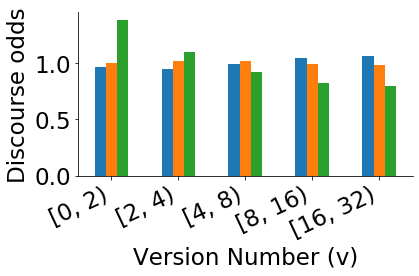

In [364]:
ax = (dist_by_version.divide( dist_by_version.mean(axis=0),axis=1)).drop('Error', axis=1).plot(kind='bar', figsize=(6,3))
ax.legend().set_visible(False)
# plt.legend(frameon=False, ncol=2, fontsize=14)#, bbox_to_anchor=(.5, .57, .42, .51))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Version Number (v)')
# plt.ylabel('p(t | v) / p(t)')
plt.ylabel('Discourse odds')
plt.xticks(rotation=25, horizontalalignment='right')
plt.savefig('figures/tag-odds-by-version.pdf', bbox_inches='tight')
plt.savefig('../presentations/acl2022/figures/tag-odds-by-version.pdf', bbox_inches='tight')

In [289]:
added_dist_by_version = (
    discourse_sent_data_with_add_dels_df
    .loc[lambda df: df['is_added'] == 1]
    .assign(c=1)
     .groupby(['version_bins', 'discourse_label'])
     ['c'].sum()
     .unstack()
     .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
    .fillna(0)
)

In [290]:
del_dist_by_version = (
    discourse_sent_data_with_add_dels_df
    .loc[lambda df: df['is_deleted'] == 1]
    .assign(c=1)
     .groupby(['version_bins', 'discourse_label'])
     ['c'].sum()
     .unstack()
     .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
    .fillna(0)
)

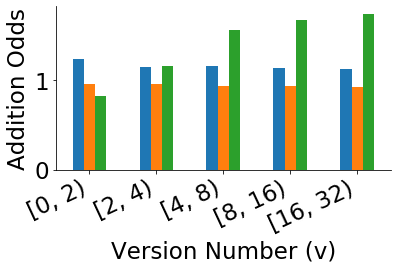

In [365]:
ax = (added_dist_by_version / dist_by_version).drop('Error', axis=1).plot(kind='bar', figsize=(6,3))
ax.legend().set_visible(False)
# plt.legend(frameon=False, ncol=2)#, bbox_to_anchor=(.5, .57, .42, .51))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Version Number (v)')
plt.ylabel('Addition Odds')
# plt.ylabel('p(t | o=add, v) / p(t | v)')
plt.savefig('figures/addition-odds-by-type-by-version.pdf',bbox_inches='tight')
plt.xticks(rotation=25, horizontalalignment='right')
plt.savefig('../presentations/acl2022/figures/addition-odds-by-type-by-version.pdf',bbox_inches='tight')

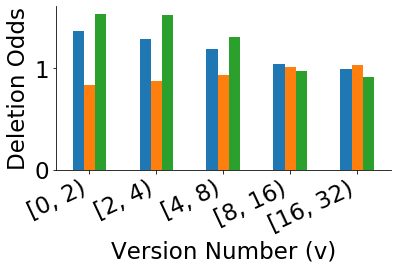

In [366]:
ax = (del_dist_by_version / dist_by_version).drop('Error', axis=1).plot(kind='bar',figsize=(6,3))
ax.legend().set_visible(False)
# plt.legend(frameon=False, ncol=2, bbox_to_anchor=(.5, .57, .42, .51))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Version Number (v)')
# plt.ylabel('p(t | o=del, v) / p(t | v)')
plt.ylabel('Deletion Odds')
plt.savefig('figures/removal-odds-by-type-by-version.pdf',bbox_inches='tight')
plt.xticks(rotation=25, horizontalalignment='right')
plt.savefig('../presentations/acl2022/figures/removal-odds-by-type-by-version.pdf',bbox_inches='tight')

# TF-IDF

In [6]:
sentence_df_no_null = sentence_df.loc[lambda df: df['sentence'].notnull()]

In [19]:
sent_df_with_add_del = sentence_df_no_null.merge(
    add_del_info,
    how='left',
    right_on=['source', 'entry_id', 'version', 'sent_idx'],
    left_on=['source','entry_id', 'version', 'sent_idx']
)

In [367]:
sent_df_with_add_del

,entry_id,version,sent_idx,sentence,source,is_deleted,is_added
0,1819591,1.0,0.0,HONG KONG — The protests that have shaken Hong...,nyt,NaN,NaN
1,1819591,1.0,1.0,"Since then, they have become a broader moveme...",nyt,NaN,NaN
2,1819591,1.0,2.0,"Over the course of several weeks, violent clas...",nyt,NaN,NaN
3,1819591,1.0,3.0,"Activists have stormed government offices, hal...",nyt,NaN,NaN
4,1819591,1.0,4.0,And the police’s use of force against demonstr...,nyt,NaN,NaN
...,...,...,...,...,...,...,...
10156709,1100535,10.0,102.0,“Both Donald and Marco got very personal and v...,guardian,NaN,NaN
10156710,1100535,10.0,103.0,I’m not going to do that.,guardian,NaN,NaN
10156711,1100535,10.0,104.0,I will happily praise Donald Trump and Marco R...,guardian,NaN,NaN
10156712,1100535,10.0,105.0,"” Butter wouldn’t melt, and etc.",guardian,NaN,NaN


In [368]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [384]:
cv = CountVectorizer(min_df=.0001, ngram_range=(2, 2), max_df=.5, stop_words='english')
# overall = (sent_df_with_add_del
#                  .assign(event_tag=lambda df: df['event_tag'].fillna('Error'))
#                  .groupby('event_tag')['sentence']
#                  .aggregate(list)
#                  .apply(lambda x: ' '.join(x))
#                 )
# X = tfidf.fit_transform(single_doc_df)

# tfidf_mat = pd.DataFrame(
#     X.todense(), 
#     columns=pd.Series(tfidf.vocabulary_).sort_values().index,
#     index=single_doc_df.index
# )

overall_counts = cv.fit_transform(sent_df_with_add_del['sentence'])

In [370]:
overall_counts

<10156714x93 sparse matrix of type '<class 'numpy.int64'>'
	with 4916371 stored elements in Compressed Sparse Row format>

In [371]:
overall_word_dist = overall_counts.mean(axis=0)

In [372]:
add_counts = cv.transform(
    sent_df_with_add_del
    .loc[lambda df: df['is_added'] == 1]
    ['sentence']
)

In [373]:
add_dist = add_counts.mean(axis=0)

In [374]:
del_counts = cv.transform(
    sent_df_with_add_del
    .loc[lambda df: df['is_deleted'] == 1]
    ['sentence']
)

In [375]:
del_dist = del_counts.mean(axis=0)

In [376]:
import numpy as np 

In [377]:
sent_counts = pd.DataFrame(
        np.vstack([
        overall_word_dist,
        del_dist,
        add_dist    
    ]),
    columns=pd.Series(cv.vocabulary_).sort_values().index,
    index=['overall', 'del', 'add']
)

In [383]:
sent_counts.loc['overall'].sort_values(ascending=False).head(100).index

Index(['grant mccool', 'editing anna', 'anna driver', 'driver grant',
       'healthcare concerns', 'era trump', 'hyper partisan', 'partisan era',
       'tom brown', 'editing joseph', 'joseph white', 'white tom',
       'selling elbows', 'elbows online', 'united states', 'new york',
       'mr trump', 'prime minister', 'white house', 'year old', 'donald trump',
       'north korea', 'islamic state', 'president donald', 'associated press',
       'said statement', 'officials said', 'twitter com', 'european union',
       'hong kong', 'trump said', 'human rights', 'president trump',
       'south korea', 'told reporters', 'police said', 'years ago',
       'supreme court', 'national security', 'trump administration',
       'social media', 'chief executive', '000 people', 'pic twitter',
       'united nations', 'news conference', 'barack obama', 'saudi arabia',
       'vice president', 'additional reporting', 'news agency',
       'secretary state', 'official said', 'said mr', 'law enfo

In [379]:
import pyperclip

t =pd.DataFrame(
    {'Overall': ['said', 'trump', 'people', 'president', 'concerns', 'government', 'year'],
     'Add/Del': ['says', 'senate', 'law', 'death', 'wednesday', 'monday', 'tuesday', ]}
).T.to_latex(header=False)
pyperclip.copy(t)

In [380]:
sent_counts.pipe(lambda df: df.loc['add'] / df.loc['overall']).sort_values(ascending=False).head(50)

president donald        4.721462
contributed report      4.576264
associated press        4.485345
los angeles             3.378264
health care             3.346232
year old                3.296674
north korea             3.219129
attorney general        3.135176
law enforcement         3.053645
donald trump            2.985929
president barack        2.882873
justice department      2.857846
supreme court           2.831715
north korean            2.797889
trump administration    2.793922
white house             2.497239
south korea             2.484384
news conference         2.450846
barack obama            2.230723
told reporters          2.215306
trump said              2.171349
vice president          2.038238
said statement          2.032685
police said             2.005417
national security       1.824789
obama administration    1.781861
foreign minister        1.733338
saudi arabia            1.674711
security council        1.662443
police officers         1.641101
climate ch

In [381]:
sent_counts.pipe(lambda df: df.loc['del'] / df.loc['overall']).sort_values(ascending=False).head(50)

contributed report      5.045831
president donald        4.869837
associated press        4.728054
health care             3.739160
los angeles             3.640117
law enforcement         3.467349
north korea             3.453322
year old                3.293908
supreme court           3.257557
attorney general        3.169214
president barack        3.125086
trump administration    3.115383
justice department      3.110513
north korean            3.088300
donald trump            3.074463
white house             2.643700
south korea             2.538903
news conference         2.521161
twitter com             2.509258
barack obama            2.414965
police said             2.281990
told reporters          2.144705
vice president          2.101206
national security       2.013524
trump said              1.984828
obama administration    1.896947
said statement          1.896934
police officers         1.815727
officials said          1.760482
security council        1.738423
foreign mi

In [89]:
add_del_sents = sent_df_with_add_del.loc[lambda df: df['is_added'].notnull() | df['is_deleted'].notnull()]

In [91]:
add_del_sents.to_csv('../eda/add-del-sents.csv')

In [ ]:
conn = sqlite3.connect(f)

In [18]:
nyt_sents

,entry_id,version,sent_idx,sentence,source
0,1819591,1.0,0.0,HONG KONG — The protests that have shaken Hong...,nyt
1,1819591,1.0,1.0,"Since then, they have become a broader moveme...",nyt
2,1819591,1.0,2.0,"Over the course of several weeks, violent clas...",nyt
3,1819591,1.0,3.0,"Activists have stormed government offices, hal...",nyt
4,1819591,1.0,4.0,And the police’s use of force against demonstr...,nyt
...,...,...,...,...,...
1465079,693203,11.0,37.0,But the president has insisted he will not agr...,nyt
1465080,693203,11.0,38.0,And Mr. Boehner in recent days reaffirmed the ...,nyt
1465081,693203,11.0,39.0,Economists across a broad spectrum agree that ...,nyt
1465082,693203,11.0,40.0,The new Republican proposal could temporarily ...,nyt


# Other

In [124]:
import pandas as pd 
t = pd.read_csv('../eda/downsampled-event-sents.csv.gz')

In [125]:
sent_lens = t['sentence'].str.split().str.len()

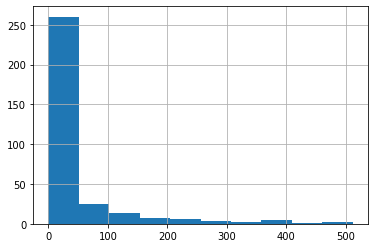

In [129]:
sent_lens.value_counts().hist(range=(0,512))

# Make Dummy Data for Sentence Detection Algorithm 

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
import pandas as pd 
import numpy as np 

In [10]:
discourse_df = pd.read_csv('../../controlled-sequence-gen/data/news-discourse-processed.tsv', sep='\t', header=None)

In [11]:
discourse_df[0] = discourse_df[0].str.split('_').str.get(0)

In [129]:
(discourse_df
 .to_csv('../../controlled-sequence-gen/data/news-discourse-high-level-labels-processed.tsv', 
         sep='\t', index=False,
         header=None
        ))

In [12]:
discourse_df[[
    'add_below_label',
    'add_above_label',
    'refactored_label'
]] = 0

In [13]:
discourse_df[0].unique()[:3].tolist()

['Main', 'Distant', 'Cause']

In [15]:
import numpy as np 
mapper = {
    'Main': 'deleted_label',
    'Distant':'edited_label',
    'Cause':'unchanged_label',
    'Error': np.nan
}

In [16]:
discourse_df[0] = discourse_df[0].map(mapper)

In [20]:
discourse_df = discourse_df.dropna().reset_index(drop=True)

In [21]:
lb = LabelBinarizer()
labels_df = pd.DataFrame(lb.fit_transform(discourse_df[0]), columns=lb.classes_)

In [22]:
t_df = pd.concat([discourse_df, labels_df], axis=1)

In [24]:
t_df = (t_df
 .rename(columns={3: 'sent_idx', 1:'sentence', 2:'entry_id'})
 .assign(version=lambda df: df['entry_id'])
 .drop(0, axis=1)
)

In [32]:
(t_df
.loc[lambda df: df['entry_id'].isin(df['entry_id'].value_counts().loc[lambda s: s > 1].index)]
 .to_csv('../modeling/data/dummy-discourse-data-in-edits-format.csv', index=False)
)